_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c1_interpolated_1750_100.csv")
training_set = data.iloc[:, 1]
training_set

0       89.200000
1       88.931092
2       88.662185
3       88.393277
4       88.124370
          ...    
1845    59.558754
1846    59.548483
1847    59.538212
1848    59.527941
1849    59.517670
Name: C1, Length: 1850, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(1750)
training_set

0       89.200000
1       88.931092
2       88.662185
3       88.393277
4       88.124370
          ...    
1745    60.186802
1746    60.182507
1747    60.178212
1748    60.173917
1749    60.169622
Name: C1, Length: 1750, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,89.200000,0.000298
1,88.931092,0.000298
2,88.662185,0.000297
3,88.393277,0.000297
4,88.124370,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

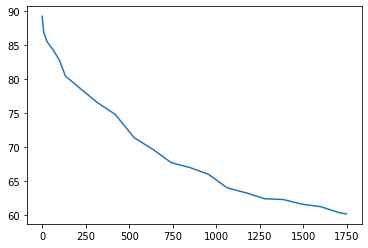

In [10]:
df.iloc[:, 0].plot()

<Axes: >

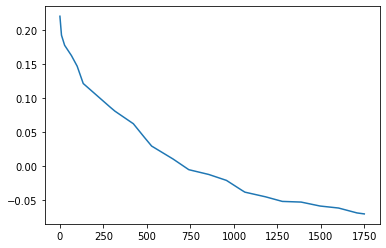

In [11]:
import numpy as np
c0 = 86.6465  # Value for C0
K0 = -0.0029  # Value for K0
K1 = -0.0003  # Value for K1
a = 0.0000    # Value for a
b = 0.0168    # Value for b
c = 2.3581    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    89.200000    88.931092    88.662185    88.393277    88.124370   
351    88.931092    88.662185    88.393277    88.124370    87.855462   
352    88.662185    88.393277    88.124370    87.855462    87.586555   
353    88.393277    88.124370    87.855462    87.586555    87.317647   
354    88.124370    87.855462    87.586555    87.317647    87.048739   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    87.855462    87.586555    87.317647    87.048739    86.794538  ...   
351    87.586555    87.317647    87.048739    86.794538    86.721709  ...   
352    87.317647    87.048739    86.794538    86.721709    86.648880  ...   
353    87.048739    86.794538    86.721709    86.648880    86.576050  ...   
354    86.794538    86.721709    86.648880    86.576050    86.503221  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   73.989683    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1300, 1, 251) (1300, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(86.6465, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0029, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0003, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0168, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.3581, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
17/17 [==============================] - 3s 31ms/step - loss: 4569.1860 - val_loss: 3627.6514
Epoch 2/500
17/17 [==============================] - 0s 4ms/step - loss: 4455.0981 - val_loss: 3556.9468
Epoch 3/500
17/17 [==============================] - 0s 4ms/step - loss: 4385.2158 - val_loss: 3500.2490
Epoch 4/500
17/17 [==============================] - 0s 4ms/step - loss: 4322.5381 - val_loss: 3444.3838
Epoch 5/500
17/17 [==============================] - 0s 5ms/step - loss: 4260.8076 - val_loss: 3389.4141
Epoch 6/500
17/17 [==============================] - 0s 5ms/step - loss: 4199.8848 - val_loss: 3334.2822
Epoch 7/500
17/17 [==============================] - 0s 4ms/step - loss: 4137.4746 - val_loss: 3277.8459
Epoch 8/500
17/17 [==============================] - 0s 4ms/step - loss: 4074.8774 - val_loss: 3222.3242
Epoch 9/500
17/17 [==============================] - 0s 4ms/step - loss: 4013.4114 - val_loss: 3167.8760
Epoch 10/500
17/17 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 332ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[62.36757703, 62.36477591, 62.36197479, 62.35917367, 62.35637255,
        62.35357143, 62.35077031, 62.34796919, 62.34516807, 62.34236695,
        62.33956583, 62.33676471, 62.33396359, 62.33116246, 62.32836134,
        62.32556022, 62.3227591 , 62.31995798, 62.31715686, 62.31435574,
        62.31155462, 62.3087535 , 62.30595238, 62.30315126, 62.30035014,
        62.28284314, 62.26323529, 62.24362745, 62.22401961, 62.20441176,
        62.18480392, 62.16519608, 62.14558824, 62.12598039, 62.10637255,
        62.08676471, 62.06715686, 62.04754902, 62.02794118, 62.00833333,
        61.98872549, 61.96911765, 61.9495098 , 61.92990196, 61.91029412,
        61.89068627, 61.87107843, 61.85147059, 61.83186275, 61.8122549 ,
        61.79264706, 61.77303922, 61.75343137, 61.73382353, 61.71421569,
        61.69460784, 61.675     , 61.65539216, 61.63578431, 61.61617647,
        61.59833333, 61.58880952, 61.57928571, 61.5697619 , 61.5602381 ,
        61.55071429, 61.54119048, 61.53166667, 61.5

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([60.1653268 , 60.16103175, 60.15673669, 60.15244164, 60.14814659,
       60.14385154, 60.13955649, 60.13526144, 60.13096639, 60.12667134,
       60.12237628, 60.11808123, 60.11378618, 60.10949113, 60.10519608,
       60.10090103, 60.09660598, 60.09231092, 60.08801587, 60.08372082,
       60.07942577, 60.07513072, 60.07083567, 60.06654062, 60.06224556,
       60.05795051, 60.05365546, 60.04936041, 60.04506536, 60.04077031,
       60.03647526, 60.03218021, 60.02788515, 60.0235901 , 60.01929505,
       60.015     , 60.01070495, 60.0064099 , 60.00211485, 59.99781979,
       59.99352474, 59.98922969, 59.98493464, 59.98063959, 59.97634454,
       59.97204949, 59.96775444, 59.96345938, 59.95916433, 59.95486928,
       59.95057423, 59.94627918, 59.94198413, 59.93768908, 59.93339402,
       59.92909897, 59.92480392, 59.92050887, 59.91621382, 59.91191877,
       59.90762372, 59.90332866, 59.89768908, 59.8874183 , 59.87714753,
       59.86687675, 59.85660598, 59.8463352 , 59.83606443, 59.82

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

25.955295752992164
12.947093256822495
